In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def linear_combination(X, w):
    return X @ w

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [4]:
def activation(X, w):
    return sigmoid(linear_combination(X, w))

In [5]:
def predict(X, w, threshold):
    return np.where(activation(X, w) > threshold, 1, 0)

Testing the above functions...

In [6]:
X = np.array([[1,20,2],[1,2,2]])
w = np.array([-1,0,1])
class_labels = predict(X, w, threshold=0.5)
print(class_labels)

[1 1]


Setting both L1 and L2 regularization rates such that their sum equals 1, allows to perform elastic regularization.  If either/both regularization isn't needed, set the corresponding rates to 0.

In [7]:
def loss(y, sigmoid_vector, weight_vector, l1_reg_rate, l2_reg_rate):
    loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
    l2_reg = l2_reg_rate * np.dot(weight_vector.T, weight_vector)
    l1_reg = l1_reg_rate * np.sum(np.abs(weight_vector))
    return loss_orig + l1_reg + l2_reg

In [8]:
def calculate_gradient(X, y, w, reg_rate):
    return X.T @ (sigmoid(linear_combination(X, w)) - y) + reg_rate * w

In [9]:
class LogisticRegression():
    def set_weight_vector(self, w):
        self.w = w
    def linear_combination(self, X):
        return X @ self.w
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def activation(self, X):
        return sigmoid(linear_combination(X))
    def predict(self, X, w, threshold):
        return np.where(activation(X) > threshold, 1, 0)
    def loss(X, y, reg_rate):
        sigmoid_vector = self.activation(X)
        loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
        reg = reg_rate * np.dot(self.w.T, self.w)
        return loss_orig + reg
    def calculate_gradient(X, y, reg_rate):
        return X.T @ (self.activation(X) - y) + reg_rate * self.w
    def update_weights(self, grad, lr):
        return self.w - grad * lr
    def gd(self, X, y, num_epochs, lr, reg_rate):
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        for i in range(num_epochs):
            grad = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(grad, lr)
        return self.w

In [36]:
def create_toy_data():
    x0 = np.random.normal(size=50).reshape(-1, 2)
    x1 = np.random.normal(size=50).reshape(-1, 2)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

In [37]:
feature_matrix, label_vector = create_toy_data()
print(feature_matrix.shape, label_vector.shape)

(50, 2) (50,)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [38]:
import itertools
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

In [39]:
import functools
def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

In [23]:
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] #a list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

In [40]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
feature_matrix_bias.shape

(50, 3)

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector) 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37, 3) (13, 3) (37,) (13,)


<AxesSubplot:>

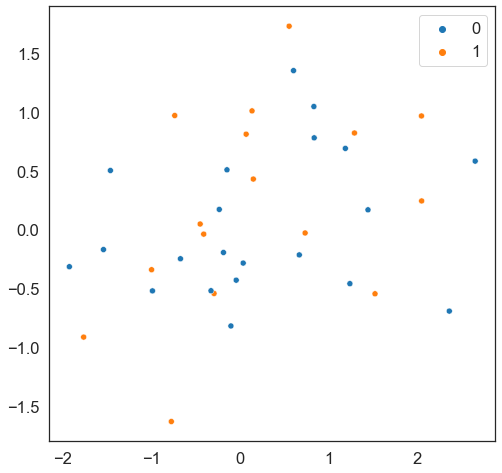

In [42]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)